In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib.pyplot as plt 

%matplotlib inline
from scipy import stats
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.stattools import adfuller, zivot_andrews

# Introducción

Cuando se realizan pruebas de raíz unitaria, se debe tener cuidado si se sospecha que ha ocurrido un cambio estructural. Cuando hay rupturas estructurales, los estadísticos de la prueba Dickey-Fuller están sesgadas hacia el no rechazo de una raíz unitaria. 

In [2]:
n =240

y = np.zeros(n) 
z = np.zeros(n)
trend = np.zeros(n) 

for i in range(0,n):
    
    e = np.random.normal(0, 1, 1)
    
    trend[i]=i
    
    if i>=120:
        y[i] = 0.50*y[i-1] + 10 + e
        
    else:
        y[i] = 0.5*y[i-1]+e
        
        
    if i==120:
        z[i] = z[i-1] + 10 + e
    else:
        z[i] = z[i-1]+e

y = pd.Series(y)    
z = pd.Series(z)  

frame = {'y':y,'z':z,'t':trend}

In [3]:
df = pd.DataFrame(frame) 
df.index = pd.period_range('1981-01-01', '2000-12-01', freq='M')


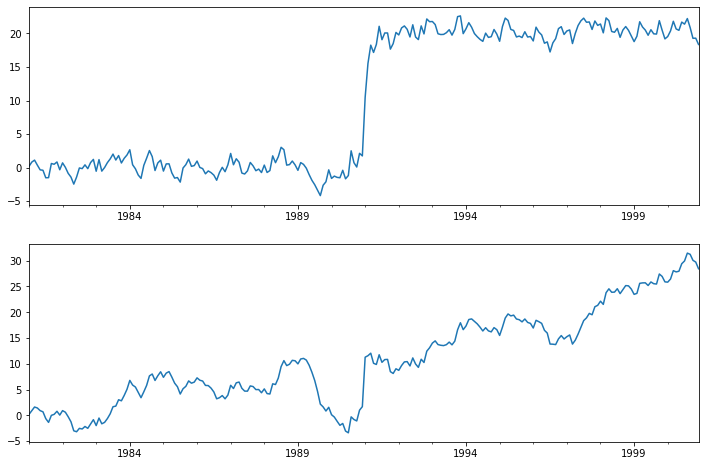

In [4]:
figure, axes = plt.subplots(2, 1)
df['y'].plot(ax=axes[0],figsize=(12,8))
df['z'].plot(ax=axes[1],figsize=(12,8))

In [5]:
df.head()

,y,z,t
1981-01,0.174822,0.174822,0.0
1981-02,0.821438,0.908849,1.0
1981-03,1.119856,1.617986,2.0
1981-04,0.373502,1.431560,3.0
1981-05,-0.328781,0.916028,4.0


In [6]:
def adf_test(timeseries,exog):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=5,regression=exog,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Test DF: Z and Y 

In [7]:
adf_test(df['y'],'ct')

Results of Dickey-Fuller Test:
Test Statistic                  -1.834230
p-value                          0.688024
#Lags Used                       0.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.997157
Critical Value (5%)             -3.429021
Critical Value (10%)            -3.137939
dtype: float64


In [8]:
adf_test(df['z'],'ct')

Results of Dickey-Fuller Test:
Test Statistic                  -2.932503
p-value                          0.151939
#Lags Used                       2.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.997485
Critical Value (5%)             -3.429179
Critical Value (10%)            -3.138031
dtype: float64


## Estimacion de la regresion

$\Delta y_t  = a_0 + \gamma y_{t − 1} + a_2t + e_t$

In [9]:
df = df.copy()
df['ly']=df['y'].shift()
df['dy']=df['y'].diff()
df['dly1']=df['dy'].shift()
df['dly2']=df['dy'].shift(periods=2)
df['dly3']=df['dy'].shift(periods=3)
df['dly4']=df['dy'].shift(periods=4)

# df['dly1']=df['dy'].shift()
# df['dly2']=df['dy'].shift(periods=2)
# df['dly3']=df['dy'].shift(periods=3)
df['lz']=df['z'].shift()
df['dz']=df['z'].diff()
df['dlz1']=df['dz'].shift()
df['dlz2']=df['dz'].shift(periods=2)
df=df[4:]

In [10]:
df.head()

,y,z,t,ly,dy,dly1,dly2,lz,dz,dlz1,dlz2
1981-01,0.174822,0.174822,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-02,0.821438,0.908849,1.0,0.174822,0.646617,NaN,NaN,0.174822,0.734028,NaN,NaN
1981-03,1.119856,1.617986,2.0,0.821438,0.298418,0.646617,NaN,0.908849,0.709137,0.734028,NaN
1981-04,0.373502,1.431560,3.0,1.119856,-0.746354,0.298418,0.646617,1.617986,-0.186426,0.709137,0.734028
1981-05,-0.328781,0.916028,4.0,0.373502,-0.702283,-0.746354,0.298418,1.431560,-0.515532,-0.186426,0.709137


In [11]:
df=df[1:]
X1 = [df['t'],df['ly'],df['dly1']]
X1 = np.column_stack(X1)
X1 = sm.add_constant(X1)

model1 = sm.OLS(df['dy'],X1)
results1 = model1.fit()

print(results1.summary(xname=['const','trend','ly']))

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.692
Date:                Thu, 16 Jul 2020   Prob (F-statistic):              0.186
Time:                        15:23:18   Log-Likelihood:                -396.55
No. Observations:                 239   AIC:                             799.1
Df Residuals:                     236   BIC:                             809.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0583      0.186     -0.313      0.7

In [12]:
X2 = [df['t'],df['lz']]
X2 = np.column_stack(X2)
X2 = sm.add_constant(X2)

model2 = sm.OLS(df['dz'],X2)
results2 = model2.fit()

print(results2.summary(xname=['const','trend','lz']))

                            OLS Regression Results                            
Dep. Variable:                     dz   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.978
Date:                Thu, 16 Jul 2020   Prob (F-statistic):             0.0528
Time:                        15:23:23   Log-Likelihood:                -371.63
No. Observations:                 239   AIC:                             749.3
Df Residuals:                     236   BIC:                             759.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1052      0.161     -0.654      0.5

## Evaluamos la hipotesis

$\gamma = a_2 =0$

In [13]:
print(results1.f_test('x1=x2=0'))


<F test: F=array([[1.69243227]]), p=0.186297558943156, df_denom=236, df_num=2>


In [14]:
print(results2.f_test('x1=x2=0'))

<F test: F=array([[2.9782255]]), p=0.05279904666616839, df_denom=236, df_num=2>


<img src="fig9.png" align="center"  width="500" height="350">

# Prueba de Zivot y Anadrews

La prueba de Zivot-Andrews analizar si la serie tiene un (y solo un) quiebre estructural. En la prueba de Zivot-Andrews la hipótesis nula es que la serie tiene una raíz unitaria con quibre estructural contra la hipótesis alternativa de que son estacionarias con quiebre. Rechazar Nulo si la estadística de valor t es inferior al valor crítico tabulado.

In [15]:
def zivot(timeseries,exog):
    print ('Results of Zivot-Andrews Test:')
    dftest = zivot_andrews(timeseries, trim=0.10, maxlag=None,regression=exog,autolag=None)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[2].items():
        dfoutput['Critical Value (%s)'%key] = value
    #dfoutput['Number of lags']=pd.Series(dftest[3:4])
    dfoutput['break']=pd.Series(dftest[4])
    print (dfoutput)

In [16]:
zivot(df['y'],'c') #Ho: raiz unitaria con quiebre en la media
# Ha: estacionaria con quiebre en la media

Results of Zivot-Andrews Test:
Test Statistic                       -12.3983
p-value                                 1e-05
Critical Value (1%)                  -5.27644
Critical Value (5%)                  -4.81067
Critical Value (10%)                 -4.56618
break                   0    118
dtype: int64
dtype: object


In [17]:
zivot(df['y'],'t')

Results of Zivot-Andrews Test:
Test Statistic                       -2.32846
p-value                              0.945184
Critical Value (1%)                  -5.03421
Critical Value (5%)                   -4.4058
Critical Value (10%)                 -4.13678
break                   0    170
dtype: int64
dtype: object


In [18]:
zivot(df['y'],'ct')

Results of Zivot-Andrews Test:
Test Statistic                       -12.1833
p-value                           0.000820623
Critical Value (1%)                  -5.57556
Critical Value (5%)                  -5.07332
Critical Value (10%)                 -4.82668
break                   0    118
dtype: int64
dtype: object


# Correci'on de la serie

In [27]:
df['d'] = (df.index >= '1990-12-01').astype(int)

In [28]:
X3 = [df['d']]
X3 = np.column_stack(X3)
X3 = sm.add_constant(X3)

model3 = sm.OLS(df['y'],X3)
results3 = model3.fit()

print(results3.summary(xname=['const','d']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     7047.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          2.76e-178
Time:                        15:57:45   Log-Likelihood:                 806.96
No. Observations:                 239   AIC:                            -1610.
Df Residuals:                     237   BIC:                            -1603.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.13e-05      0.001     -0.015      0.9

In [29]:
pred = results3.predict(X3)

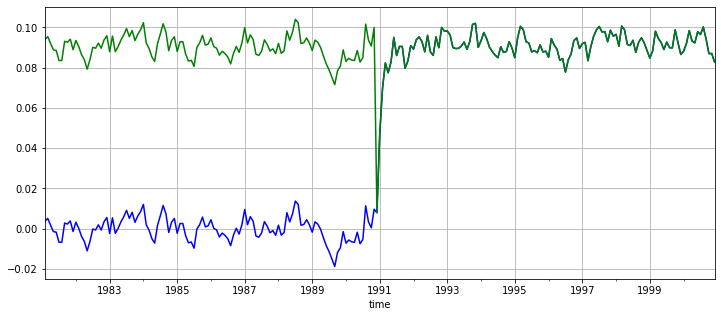

In [30]:
df['new']=df['y']*df['d']+(df['y']+0.0902)*(1-df['d']) 

df['pred']= pred
df['res']=df['y']-df['pred']

plt.figure(figsize=(12,5))
plt.xlabel('time')

ax1 = df.y.plot(color='blue', grid=True, label='original')
# ax2 = df.pred.plot(color='red', grid=True, label='fixed')
ax3 = df.new.plot(color='green', grid=True, label='fixed')

plt.show()

In [31]:
df.to_excel('data_ec.xlsx')